# Uniqueness Investigation
1. Measure the unique features across individual
2. Matching: tell how many people are hit by RNG fields (most informative, divided by the total number of records
3. How much information do we really need to identify individuals --> So far we only know some features that are informative.  Next step is how much we need to know to uniquely identify an individual
4. Step through 1 RNG reading, then try 2, etc. we should show higher uniquessness in the data as we increase the number of readings
5. Need to understand how we design the test set for the patients linking.  Should also include some patients that were not in the original dataset in order to determine the precision of said target matching.

## This NB:
> **Conclusion From Relative Entropy Evaluation:** The highest values are 0.289, 0.273, and 0.266, for the following fields, respectively: 'FairlyActiveMinutes', 'VeryActiveDistance', and 'LightlyActiveMinutes'.  Calories and total steps were both relatively uninformative.

## Goals
1. Assume to conduct the uniqueness analysis on each activity separately. In other words, we compute a uniqueness score, for each activity. Here, we can start by considering the top-3 activity that you have already identified using the KL-divergence.
2. Consider a threshold value to match the reading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=12) 
import random

In [2]:
################## DATA FRAME ##################
datafile = 'Data/Fitbit_Kaggle/dailyActivity_merged.csv'
fields = ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 
          'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 
          'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

#pd.set_option('display.max_rows', 100)
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
selected_data = df[['Id','FairlyActiveMinutes']]
n_rows, n_cols = df.shape
display(selected_data.head(32))

,Id,FairlyActiveMinutes
0,1503960366,13
1,1503960366,19
2,1503960366,11
3,1503960366,34
4,1503960366,10
5,1503960366,20
6,1503960366,16
7,1503960366,31
8,1503960366,12
9,1503960366,8


In [3]:
IDs = selected_data['Id'].unique()
individualAct = dict()
for Id in IDs:
    act = selected_data[selected_data['Id']==Id]
    individualAct[Id] = act['FairlyActiveMinutes'].tolist()

In [4]:
## Get the activity in the data
data_act = list(selected_data['FairlyActiveMinutes'].unique())

In [5]:
def isHit(activity, query, ths):
    
    hits = list()
    for th in ths:
        hit = False
        i = 0
        for j in range(0,len(activity)):
            #print(query[j])
            if (abs(query[i] - activity[j])<=th):
                i = i + 1
            
                if i == len(query):
                    hit = True
                    break
        
        hits.append(hit)
    return hits


In [6]:
def uniqueness(queries, domain, k, l, uniq_score, individuals, ths):
    '''
    queries:
    domain:
    k: limit 
    l: current iteration I think, current number of entries more like
    individuals: individualAct[Id] = act['FairlyActiveMinutes'].tolist()
    '''
    
    print(queries[0])
    print(len(queries))
    print(len(individuals.keys()))
    
    if l > k:
        print("L > K!!!")
        return uniq_score
    
    present_queries = []
    query_matches = dict()
    
    for query in queries:
        match = dict()
        for th in ths:
            match[th] = []
            
        inData = False
        #print(query)
        for Id in individuals:
            ind_act = individuals[Id]
                
            hits = isHit(ind_act, query, ths)
                
            for i in range(0,len(ths)):
                hit = hits[i]
                
                if hit:
                    match[ths[i]].append(Id)
                    inData = True
                    #print(ths[i])
                    #print(Id)
                    #print(match)
        if inData:
            present_queries.append(query)
            query_matches[str(query)] = match
            #print(match)
    
    for i in range(0, len(ths)):
        uniquesId = []
        th = ths[i]
        #print(th)
        
        for keyquery in query_matches:
            match = query_matches[keyquery]
            
            matchTH = match[th]
            #print(keyquery)
            #print(matchTH)
            if len(list(set(matchTH))) == 1:
                #print("Unique")
                uniquesId.append(matchTH[0]) 
        
        score = (1.0*len(list(set(uniquesId))))/len(individuals.keys())
        uniq_score.append((l,th,score))
                        
    l = l + 1
    newqueries = []
    for query in present_queries:  
        for val in domain:
            newquery = query.copy()
            newquery.append(val)
            newqueries.append(newquery)
                   
    return uniqueness(newqueries, domain, k, l, uniq_score, individuals, ths)
            

The following block takes forever to run

In [7]:
#uniqueness up to 3 readings with th=0 and th=2
uniqueScores = list()
start_query = [[a] for a in data_act]
uniqueScores = uniqueness(start_query, data_act, 3, 1, uniqueScores, individualAct, [0, 2, 5])

[13]
81
33
[13, 13]
6561
33
[13, 13, 13]
510138
33
[13, 13, 13, 13]
36073836
33
L > K!!!


In [8]:
uniqueScores

[(1, 0, 0.21212121212121213),
 (1, 2, 0.06060606060606061),
 (1, 5, 0.030303030303030304),
 (2, 0, 0.8181818181818182),
 (2, 2, 0.36363636363636365),
 (2, 5, 0.21212121212121213),
 (3, 0, 0.9393939393939394),
 (3, 2, 0.6666666666666666),
 (3, 5, 0.36363636363636365)]

## Visualization

In [9]:
my_xs = []
my_ys1 = []
my_ys2 = []
my_ys3 = []

for idx, item in enumerate(uniqueScores):
    if idx%3==0:
        my_xs.append(item[0])
        my_ys1.append(item[2])
    elif idx%3==1:
        my_ys2.append(item[2])
    else:
        my_ys3.append(item[2])

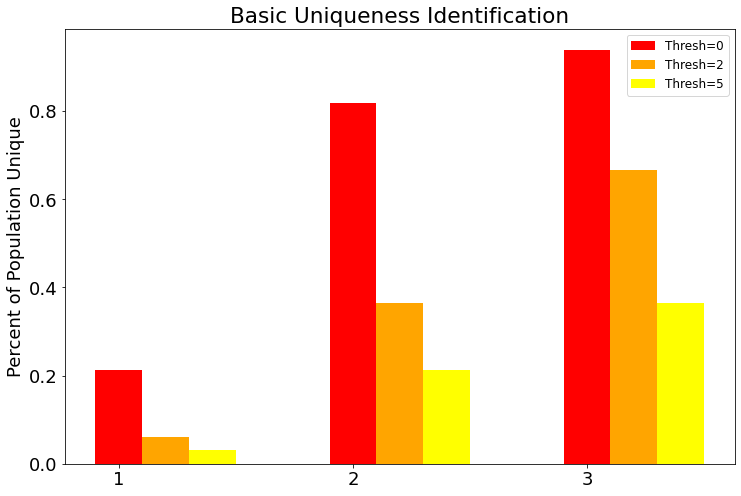

In [10]:
N = 5
width = 0.2       # the width of the bars
plt.figure(figsize=(12,8))

rects1 = plt.bar(my_xs, my_ys1, width, color='r')
rects2 = plt.bar(np.array(my_xs, int)+width, my_ys2, width, color='orange')
rects3 = plt.bar(np.array(my_xs, float)+2*width, my_ys3, width, color='yellow')


# add some text for labels, title and axes ticks
plt.ylabel('Percent of Population Unique')
plt.xlabel('')
plt.title('Basic Uniqueness Identification')
plt.xticks(my_xs)
plt.legend((rects1[0], rects2[0], rects3[0]), ('Thresh=0', 'Thresh=2', 'Thresh=5'))

plt.show()